In [42]:
import pandas as pd
import psycopg2
from typing import Union
from substrateinterface import SubstrateInterface

# Database connection parameters (replace with your values)
db_params = {
    'dbname': 'postgres',
    'host': 'localhost',
    'port': '5432'
    # 'user': 'your_username',
    # 'password': 'your_password',
}

# Establish the connection
conn = psycopg2.connect(**db_params)

# SQL query to get rewards for nominators
nominator_rewards_sql = """
SELECT
    era AS era_id,
    account_id AS nominatorId,
    amount AS nominatorReward
FROM public.staking_reward
WHERE validator_id != account_id;
"""

# SQL query to get rewards for validators
validator_rewards_sql = """
SELECT
    era AS era_id,
    account_id AS validatorId,
    amount AS validatorReward
FROM public.staking_reward
WHERE validator_id = account_id;
"""

# Execute the queries and store the results in pandas DataFrames
df_nominator_rewards = pd.read_sql(nominator_rewards_sql, conn)
df_validator_rewards = pd.read_sql(validator_rewards_sql, conn)

# Close the database connection
conn.close()

# substrate = SubstrateInterface(url="wss://rpc.polkadot.io")
#
# def encode_to_ss58(public_id: Union[str, bytes], ss58_format: int = None) -> str:
#     return substrate.ss58_encode(public_key=public_id, ss58_format=ss58_format)
#
# df_nominator_rewards['ss58_address'] = df_nominator_rewards['nominatorid'].apply(encode_to_ss58)
# df_validator_rewards['ss58_address'] = df_validator_rewards['validatorid'].apply(encode_to_ss58)
#
# df_nominator_rewards.drop(columns = ['nominatorid'], inplace=True)
# df_validator_rewards.drop(columns = ['validatorid'], inplace=True)
#
# # Rename the column in df_rewards to match df_
# df_nominator_rewards = df_nominator_rewards.rename(columns={'ss58_address': 'nominatorId', 'nominatorreward': 'nominatorReward'})
# df_validator_rewards = df_validator_rewards.rename(columns={'ss58_address': 'validatorId', 'validatorreward': 'validatorReward'})

/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_3107/3794114322.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nominator_rewards = pd.read_sql(nominator_rewards_sql, conn)
/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_3107/3794114322.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_validator_rewards = pd.read_sql(validator_rewards_sql, conn)


In [49]:
nominators_data = pd.read_pickle('nominator_data_full.pkl')
nominators_data.drop(columns=['id'], inplace=True)
nominators_data.rename(columns={'selfBonded': 'validatorBonded',
                                'amount': 'nominatorBonded'}, inplace=True)
# Subsetting the DataFrame
df_nominators = nominators_data[
    ['era_id', 'nominatorId', 'validatorId', 'nominatorsCount', 'nominatorBonded', 'totalBonded']]

df_validators = nominators_data[['era_id', 'validatorId', 'nominatorsCount', 'validatorBonded', 'totalBonded']]

# Group by era_id and validatorId and then calculate the mean
# df_validators_grouped = df_validators.groupby(['era_id', 'validatorId']).mean().reset_index()
df_validators_grouped = df_validators.groupby(['era_id', 'validatorId']).last().reset_index()

In [51]:
df_nominators['nominatorBonded'] = pd.to_numeric(df_nominators['nominatorBonded'], errors='coerce')
df_validators_grouped['validatorBonded'] = pd.to_numeric(df_validators_grouped['validatorBonded'], errors='coerce')


/var/folders/wf/5crfrw2n2bj95k071nfq9hcw0000gn/T/ipykernel_3107/3058786840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nominators['nominatorBonded'] = pd.to_numeric(df_nominators['nominatorBonded'], errors='coerce')


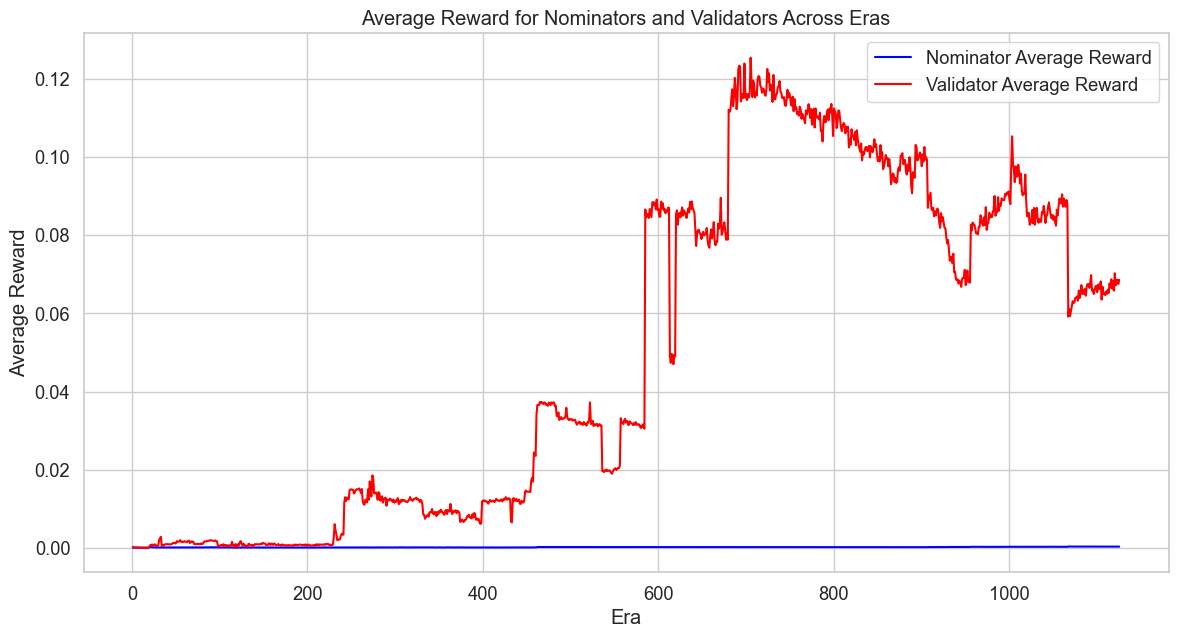

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_nominator_rewards, df_validators_rewards, df_nominators, and df_validators are loaded as previously shown

# Group by era_id and sum the reward values
nominator_reward_grouped = df_nominator_rewards.groupby('era_id')['nominatorreward'].sum()
validator_reward_grouped = df_validator_rewards.groupby('era_id')['validatorreward'].sum()

# Group by era_id and sum the bonded values
nominator_bonded_grouped = df_nominators.groupby('era_id')['nominatorBonded'].sum()
validator_bonded_grouped = df_validators_grouped.groupby('era_id')['validatorBonded'].sum()

# Calculate the average reward by dividing the sum of rewards by the sum of bonded values for each era
average_nominator_reward = nominator_reward_grouped / nominator_bonded_grouped
average_validator_reward = validator_reward_grouped / validator_bonded_grouped

# Plot the average rewards for both nominators and validators across eras
plt.figure(figsize=(14, 7))
plt.plot(average_nominator_reward.index, average_nominator_reward.values, label='Nominator Average Reward', color='blue')
plt.plot(average_validator_reward.index, average_validator_reward.values, label='Validator Average Reward', color='red')

# Add title and labels
plt.title("Average Reward for Nominators and Validators Across Eras")
plt.xlabel("Era")
plt.ylabel("Average Reward")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Now, merge the two DataFrames
df_nominators_join = pd.merge(df_nominators,
                              df_nominator_rewards,
                              on=['era_id', 'nominatorId'],
                              how='left')
# Merge rewards into df_validators_grouped
df_validators_join = pd.merge(df_validators_grouped,
                              df_validator_rewards,
                              on=['era_id', 'validatorId'],
                              how='left')

nominatorBonded     object
nominatorReward    float64
dtype: object


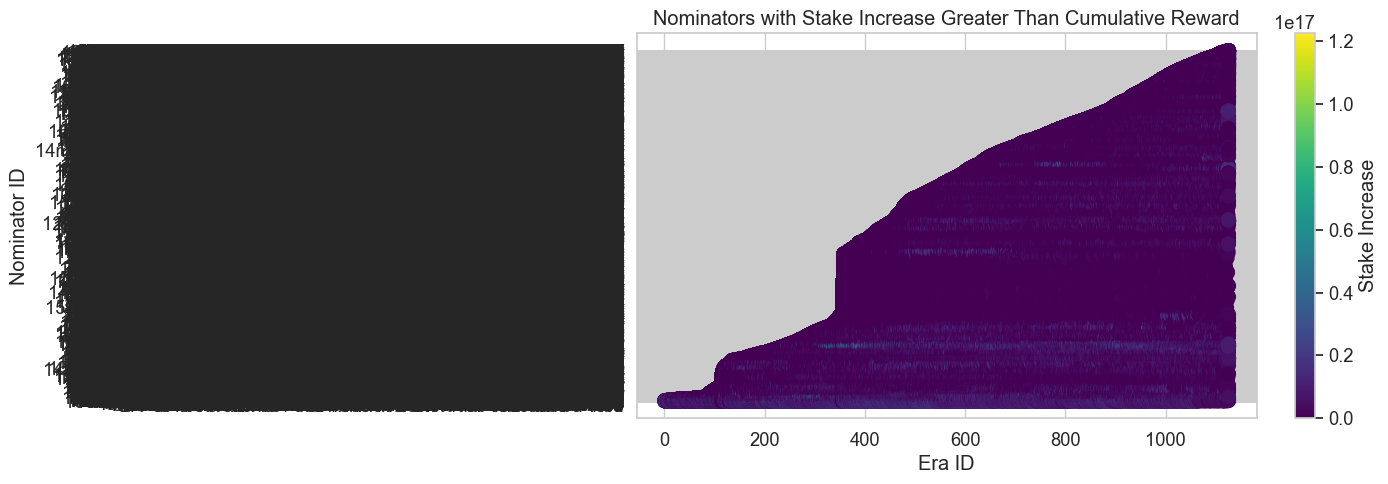

In [31]:
# Check the data types of the relevant columns
print(df_nominators_join[['nominatorBonded', 'nominatorReward']].dtypes)

# Convert the columns to numeric types if necessary
df_nominators_join['nominatorBonded'] = pd.to_numeric(df_nominators_join['nominatorBonded'], errors='coerce')
df_nominators_join['nominatorReward'] = pd.to_numeric(df_nominators_join['nominatorReward'], errors='coerce')

# Proceed with the calculation
df_nominators_join['stake_increase'] = df_nominators_join.groupby('nominatorId')['nominatorBonded'].diff().fillna(0)
df_nominators_join['reward_cumsum'] = df_nominators_join.groupby('nominatorId')['nominatorReward'].cumsum()

# Filter nominators whose stake increased more than their cumulative reward
mask = df_nominators_join['stake_increase'] > df_nominators_join['reward_cumsum']
filtered_df = df_nominators_join[mask]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_df['era_id'], filtered_df['nominatorId'], c=filtered_df['stake_increase'], cmap='viridis', s=100)
plt.colorbar(label='Stake Increase')
plt.xlabel('Era ID')
plt.ylabel('Nominator ID')
plt.title('Nominators with Stake Increase Greater Than Cumulative Reward')
plt.savefig('Nominators with Stake Increase Greater Than Cumulative Reward.pdf')
plt.show()

In [33]:
window_size = 1

# For Nominators
df_nominators['rolling_nominator_bonded'] = df_nominators['nominator_bonded'].rolling(window=window_size).mean()
df_nominators['rolling_nominator_reward'] = df_nominators['nominator_reward'].rolling(window=window_size).mean()

# For Validators
df_validators['rolling_validator_bonded'] = df_validators['validator_bonded'].rolling(window=window_size).mean()
df_validators['rolling_validator_reward'] = df_validators['validator_reward'].rolling(window=window_size).mean()

/Users/germanrodikov/miniforge3/envs/PolkaDot/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


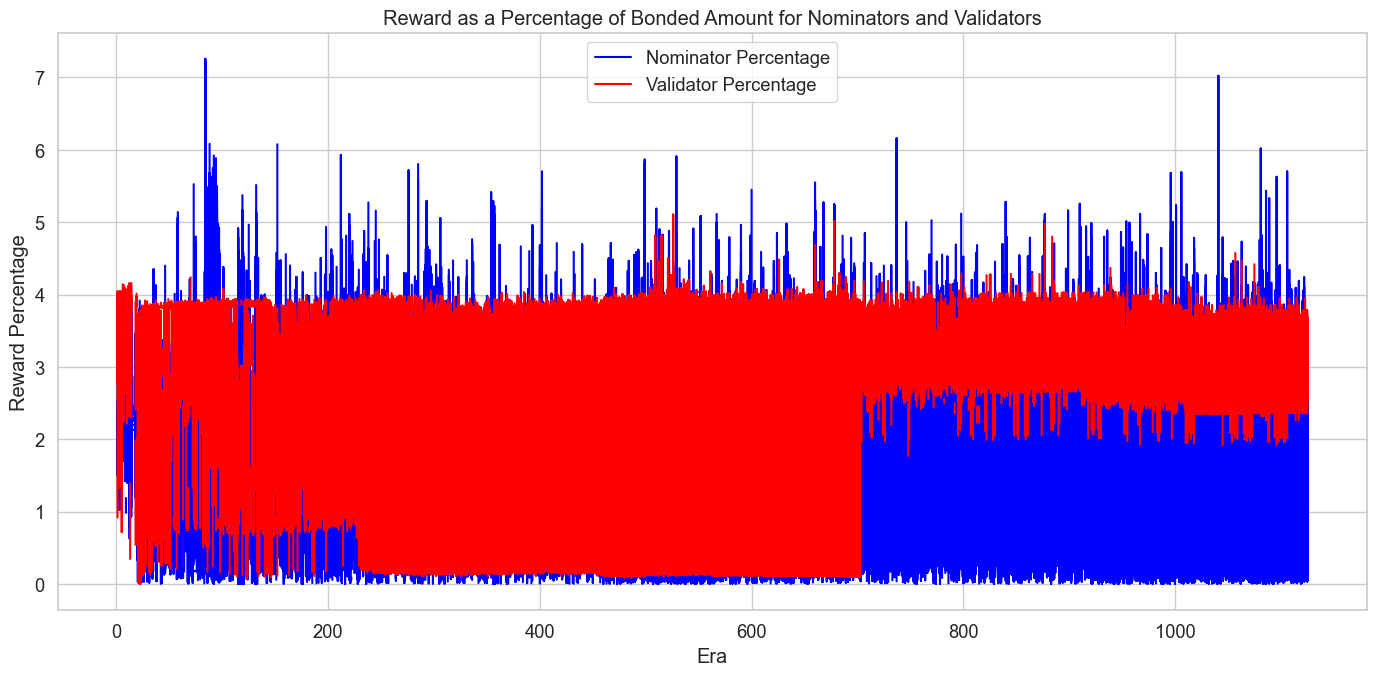

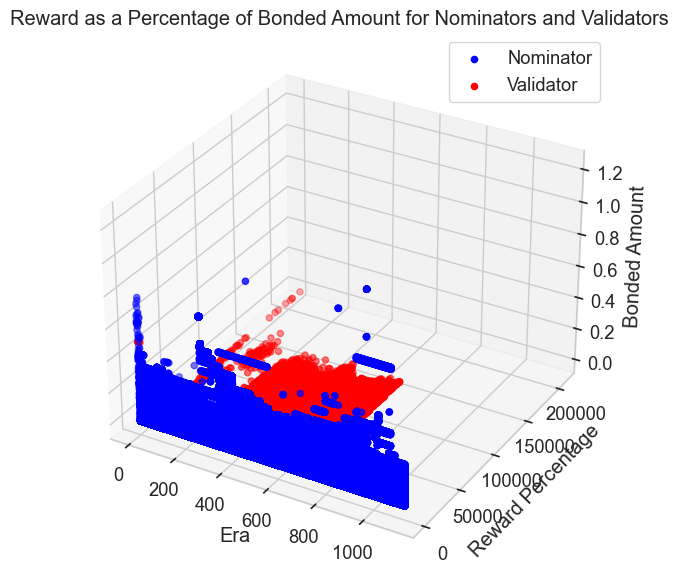

In [37]:
# Assuming the dataframes are loaded as previously shown
# Calculate reward as a percentage of the bonded amount
df_nominators['rolling_nominator_reward_percentage'] = (df_nominators['rolling_nominator_reward'] / df_nominators['rolling_nominator_bonded']) * 100
df_validators['rolling_validator_reward_percentage'] = (df_validators['rolling_validator_reward'] / df_validators['rolling_validator_bonded']) * 100

# Create the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot for Nominators
ax.scatter(df_nominators['era'], df_nominators['rolling_nominator_reward_percentage'], df_nominators['rolling_nominator_bonded'], label='Nominator', color='blue')

# Create the 3D scatter plot for Validators
ax.scatter(df_validators['era'], df_validators['rolling_validator_reward_percentage'], df_validators['rolling_validator_bonded'], label='Validator', color='red')

# Add title and labels
ax.set_title("Reward as a Percentage of Bonded Amount for Nominators and Validators")
ax.set_xlabel("Era")
ax.set_ylabel("Reward Percentage")
ax.set_zlabel("Bonded Amount")

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [63]:
df_nominators.rename(columns = {'era': 'era_id', 'nominator_id': 'nominatorId'}, inplace = True)

In [64]:
# Filter the DataFrames to only include records with era_id up to 1125
df_nominator_rewards = df_nominator_rewards[df_nominator_rewards['era_id'] <= 1125]
df_validator_rewards = df_validator_rewards[df_validator_rewards['era_id'] <= 1125]

# Now, merge the two DataFrames again
df_nominators_join = pd.merge(df_nominators,
                              df_nominator_rewards,
                              on=['era_id', 'nominatorId'],
                              how='left')
df_validators_join = pd.merge(df_validators_grouped,
                              df_validator_rewards,
                              on=['era_id', 'validatorId'],
                              how='left')

          era_id                                       nominatorId  \
0              1  16iNp8A8EU6naBzvDmJR2i4hgP5EQnZHeGQ6omKeK9C4NTkp   
1              1  12713bbq45c66CN9AD7yusSXWE1kY91DcMpjVcB2rXqZKy2w   
2              1  14AoK8VSrHFxZijXhZGSUipHzZbUgo2AkmEaviD9yxTb1ScX   
3              1  14mR4xpU4BwYTTFNwMJ7KJ81yqNiNxGUFL4e3GxVsN27YNTE   
4              1   1dy8EbtmghvmcsctTZvKBfNx8b2qFs9RUnRrkwELsW2gC5N   
...          ...                                               ...   
30776807    1125  15dYrHjox33mDK5nvUM6wJNjZxapb2VkjemCZB5LMpEz9tap   
30776808    1125  13wue8kUtL8HWpA82baVVzbYP4KGpTaZUJVevKfVLmZ9NyDF   
30776809    1125  15U71s4RpxBT2jDAuMpJ4HntiJn2rcxT3ycxzi4N3vfdYZWo   
30776810    1125  13W642cHE7g8UoHJaiEaxhncrFgFqFy4KEq5NvC6HKEL8Ydc   
30776811    1125  13xJ5jtNk3y2GspLN84Gb24SNSZMYjGMYJBpLi3575UQnFqi   

                                              validator_id  nominatorsCount  \
0         12jiWV8yksQuvzEyh98z2BegL7sd8W2NzUcE1Noni9bjKtsg                4   
1

In [70]:
print("Unique era_id in df_nominators:", df_nominators['era_id'].nunique())
print("Unique era_id in df_nominator_rewards:", df_nominator_rewards['era_id'].nunique())

print("Unique nominatorId in df_nominators:", df_nominators['nominatorId'].nunique())
print("Unique nominatorId in df_nominator_rewards:", df_nominator_rewards['nominatorId'].nunique())

print("Unique era_id in df_validators_grouped:", df_validators_grouped['era_id'].nunique())
print("Unique era_id in df_validator_rewards:", df_validator_rewards['era_id'].nunique())

print("Unique validatorId in df_validators_grouped:", df_validators_grouped['validatorId'].nunique())
print("Unique validatorId in df_validator_rewards:", df_validator_rewards['validatorId'].nunique())

Unique era_id in df_nominators: 1125
Unique era_id in df_nominator_rewards: 1125
Unique nominatorId in df_nominators: 80709
Unique nominatorId in df_nominator_rewards: 76442
Unique era_id in df_validators_grouped: 1125
Unique era_id in df_validator_rewards: 1125
Unique validatorId in df_validators_grouped: 1185
Unique validatorId in df_validator_rewards: 1122


In [71]:
missing_nominator_ids = set(df_nominators['nominatorId']) - set(df_nominator_rewards['nominatorId'])
print("Missing nominatorId values:", missing_nominator_ids)

missing_validator_ids = set(df_validators_grouped['validatorId']) - set(df_validator_rewards['validatorId'])
print("Missing validatorId values:", missing_validator_ids)

Missing nominatorId values: {'13DoW2BLJ4xe8NcadmUxnP8LS8FtWyf1jmF5htzA8dCR7Gww', '14wzAMzmiXoVBwcQhRQjAQT15rvreNr47NepnCmGpzivae79', '15oDBDzSoajuu8TnY6eQP6ztftwq2desnYpmLBdjbCZbwCr3', '1ZFq22B8ohipRHvyCzJpgWGSkG3J5icBAW1ED5mQ5FXMmqb', '15apTsswF96S7nTfZbbRjUhUT8D5d1wpW2hqTZHdj2ZfUx91', '1navFBrqYc3SgMAtuBcFd59YBnSiybtbMtqdzPGSGZxVPwK', '14XYtLP9oRwfYHjvjAuxQCZtsPEk6JvxTkZZbXr5e75E4eTD', '12bmDQhtaCYLHYRLMKoV4VtSNZ4Ucu5ZFoCxWFfdPB9dXDCY', '12TGfWyXLq5Qvckb8syjgy97dXmZX73VBDuAK4pbAgzZSr9x', '14zuqAkbRX14S44LGMKLeYgFq2f8AzwY3nKCWES6EdECynfh', '12KVrqB4RSSF5WQ8vUKMuYN29gfpsnRUwvEcDNNrxzEGB3dN', '15rqjyGiPTEx2KDry6ngBTsDQMpNF1eNEPVRNja3w6tgrsVB', '16Q9VxXvNJbUvKTop7yMtWKrdw9i38UWDoNpBxjVVHKDa9KV', '13GV97VypnFGNerzxumcSMVnTAyWeTC3csaxRwojgY6byNPe', '12E9LUTEUTbKTd5Y4DChByvPTVMSo3ggwpLAEYHasQYnbyYw', '1551e276yfc9VGCsuLkwzwY3bMZPEk2jiKDMHKoobtAZSaUz', '12finMzCttYWtAgL4L124yCFt76avCzts3Xdes9Fkbe5wiZX', '16StwTo38BhsYZJLLSwxv2Uox4zQzxyF36f27D4yXWohSKaG', '129TLqtMByKmYcwNhLJREdu3cmdMVTpJ6Q36

In [ ]:
from substrateinterface import SubstrateInterface
from typing import Union, List

# Create an instance of SubstrateInterface
substrate = SubstrateInterface(url="wss://rpc.polkadot.io")

def encode_to_ss58(public_id: Union[str, bytes], ss58_format: int = None) -> str:
    return substrate.ss58_encode(public_key=public_id, ss58_format=ss58_format)

# Assume public_keys is a list of public keys you want to encode
public_keys = df_nominator_rewards.nominatorid.to_list()

# Encode all public keys and store the results in a list
encoded_addresses = [encode_to_ss58(public_key) for public_key in public_keys]

# Print the results
for public_key, encoded_address in zip(public_keys, encoded_addresses):
    print(f"Public Key: {public_key}, Encoded SS58 Address: {encoded_address}")

In [11]:
import pandas as pd
import numpy as np

In [21]:
df_nominators_join = pd.read_pickle('df_nominators_last.pkl')
df_validators_join = pd.read_pickle('df_validators_last.pkl')
df_nominators = df_nominators_join.rename(columns={'era_id': 'era',
                                                   'nominatorId': 'nominator_id',
                                                   'validatorId': 'validator_id',
                                                   'nominatorBonded': 'nominator_bonded',
                                                   'totalBonded': 'total_bonded',
                                                   'nominatorReward': 'nominator_reward',
                                                   })
df_validators = df_validators_join.rename(columns={'era_id': 'era',
                                                   'validatorId': 'validator_id',
                                                   'validatorBonded': 'validator_bonded',
                                                   'totalBonded': 'total_bonded',
                                                   'validatorReward': 'validator_reward',
                                                   })

In [22]:
def compute_retention_rate(df, start_era, after_eras):
    """
    Compute retention rate given a start era and a list of eras after the start.
    Returns a list of retention rates corresponding to the eras provided in 'after_eras'.
    """
    # Identify nominators who were bonded in the start era
    initial_nominators = set(df[df['era'] == start_era]['nominator_id'].unique())
    if not initial_nominators:
        return [None] * len(after_eras)

    retention_rates = []
    for after_era in after_eras:
        after_nominators = set(df[df['era'] == start_era + after_era]['nominator_id'].unique())
        retained_nominators = initial_nominators.intersection(after_nominators)
        retention_rate = len(retained_nominators) / len(initial_nominators) * 100
        retention_rates.append(retention_rate)

    return retention_rates

all_eras = df_nominators['era'].unique()
rolling_retention_30 = []
rolling_retention_50 = []
rolling_retention_100 = []

for era in all_eras[:-100]:  # We omit the last 100 eras as we want to compute retention up to 100 eras after each era
    retention_30, retention_50, retention_100 = compute_retention_rate(df_nominators, era, [30, 50, 100])
    rolling_retention_30.append(retention_30)
    rolling_retention_50.append(retention_50)
    rolling_retention_100.append(retention_100)

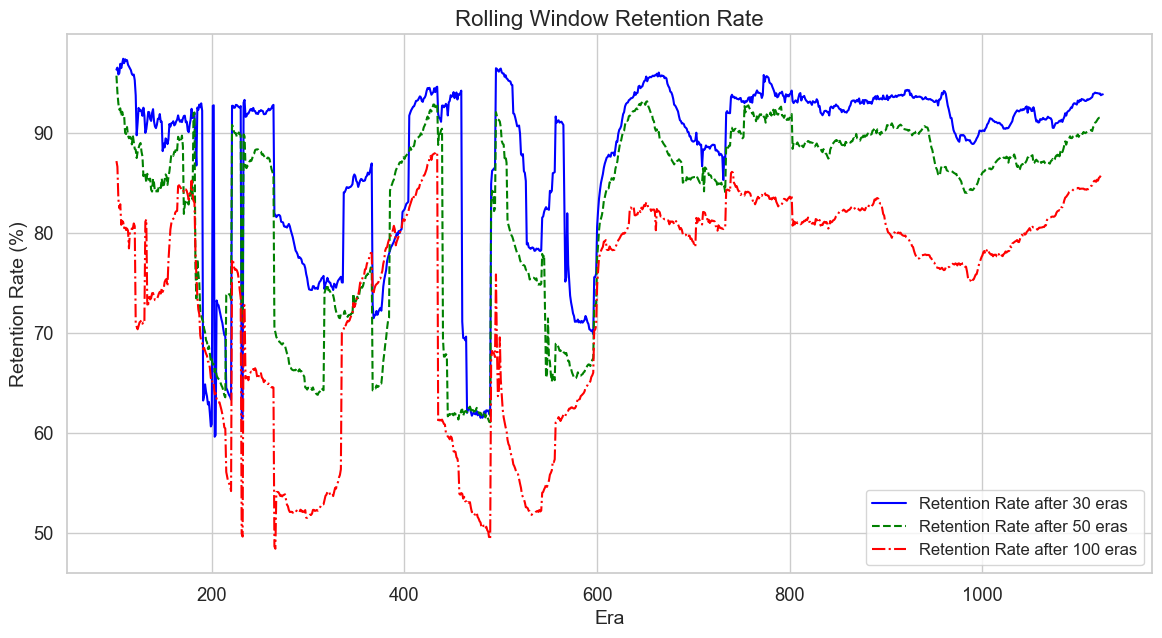

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme and default plot settings
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the data with different line styles and colors
sns.lineplot(x=all_eras[100:], y=rolling_retention_30, linestyle='-', color="blue", label="Retention Rate after 30 eras", ax=ax)
sns.lineplot(x=all_eras[100:], y=rolling_retention_50, linestyle='--',  color="green", label="Retention Rate after 50 eras", ax=ax)
sns.lineplot(x=all_eras[100:], y=rolling_retention_100, linestyle='-.', color="red", label="Retention Rate after 100 eras", ax=ax)

# Set the axis labels and title with larger font size
ax.set_xlabel("Era", fontsize=14)
ax.set_ylabel("Retention Rate (%)", fontsize=14)
ax.set_title("Rolling Window Retention Rate", fontsize=16)

# Configure the legend
ax.legend(fontsize=12)

# Show the plot
plt.savefig("Rolling Window Retention Rate.pdf")
plt.show()


In [ ]:
# Merge the dataframes on era and validator_id
df = pd.merge(df_nominators, df_validators,  how='left', left_on=['era','validator_id'], right_on = ['era','validator_id'])

# Create a new dataframe by grouping by era and validator_id and summing nominator_reward
grouped_nominator_reward = df.groupby(['era', 'validator_id'])['nominator_reward'].sum().reset_index()
grouped_nominator_reward = grouped_nominator_reward.rename(columns={"nominator_reward": "sum_nominator_reward"})

# Merge this new dataframe back to your original dataframe
df = pd.merge(df, grouped_nominator_reward,  how='left', left_on=['era', 'validator_id'], right_on = ['era', 'validator_id'])

# Calculate total_reward_current as sum of sum_nominator_reward and validator_reward
df['total_reward_current'] = df['sum_nominator_reward'] + df['validator_reward']

# Continue your calculations as before
df['total_reward_previous'] = df['total_reward_current'].shift(1)
df['nominator_reward_previous'] = df['nominator_reward'].shift(1)
df['validator_reward_previous'] = df['validator_reward'].shift(1)

df['total_bonded_current'] = df['nominator_bonded'] + df['validator_bonded']
df['total_bonded_previous'] = df['total_bonded_current'].shift(1)
df['nominator_bonded_previous'] = df['nominator_bonded'].shift(1)
df['validator_bonded_previous'] = df['validator_bonded'].shift(1)

df.loc[df['nominator_id'] != df['nominator_id'].shift(1), ['nominator_reward_previous', 'nominator_bonded_previous']] = np.nan
df.loc[df['validator_id'] != df['validator_id'].shift(1), ['validator_reward_previous', 'validator_bonded_previous']] = np.nan

df = df[['era', 'nominator_id', 'validator_id', 'nominator_reward', 'validator_reward', 'total_reward_current',  'nominator_reward_previous', 'validator_reward_previous', 'total_reward_previous', 'total_bonded_current', 'nominator_bonded', 'validator_bonded', 'total_bonded_previous', 'nominator_bonded_previous', 'validator_bonded_previous']]

In [25]:
import pandas as pd

# Your existing code
df['validator_switch'] = ((df['validator_id'] != df['validator_id'].shift(1)) & (df['nominator_id'] == df['nominator_id'].shift(1))).astype(int)
df['higher_reward_next_era'] = df.groupby('nominator_id')['total_reward_current'].shift(-1) > df['total_reward_current']

# Group by higher_reward_next_era and era, then calculate the mean switch rate for each group
grouped = df.groupby(['higher_reward_next_era', 'era'])['validator_switch'].mean().reset_index()

# Use the rolling window approach to calculate the mean switch rate for 20 eras
window_size = 20

# Apply rolling window to both higher_reward_next_era groups
rolling_means = {}
for reward in [True, False]:
    rolling_means[reward] = grouped[grouped['higher_reward_next_era'] == reward]['validator_switch'].rolling(window=window_size).mean()

# Create a new DataFrame with the rolling means
rolling_df = pd.DataFrame({'higher_reward_next_era': [True] * len(rolling_means[True]) + [False] * len(rolling_means[False]),
                           'rolling_mean_switch_rate': pd.concat([rolling_means[True], rolling_means[False]]).reset_index(drop=True)})

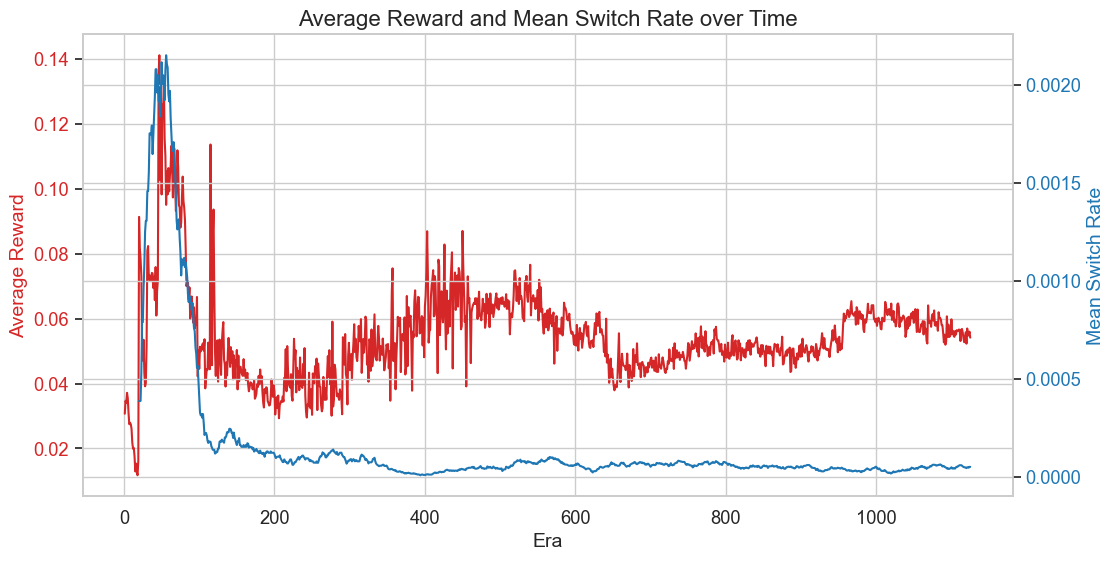

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme and default plot settings
sns.set_theme(style="whitegrid", font_scale=1.2)

# Average reward and switch rate for each era
era_data = df.groupby('era').agg({'total_reward_current': 'mean', 'validator_switch': 'mean'})

# Rolling mean switch rate for 20 eras
window_size = 20
era_data['rolling_mean_switch_rate'] = era_data['validator_switch'].rolling(window=window_size).mean()

# Create a figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the average reward with ax1
color = 'tab:red'
ax1.set_xlabel('Era', fontsize=14)
ax1.set_ylabel('Average Reward', fontsize=14, color=color)
sns.lineplot(data=era_data, x=era_data.index, y=era_data['total_reward_current']/10**12/365, ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mean Switch Rate', fontsize=14, color=color)
sns.lineplot(data=era_data, x=era_data.index, y=era_data['rolling_mean_switch_rate'], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the title with a larger font size
plt.title('Average Reward and Mean Switch Rate over Time', fontsize=16)

# Show the plot
plt.savefig('Average Reward and Mean Switch Rate over Time.pdf')
plt.show()


Summary statistics for nominator rewards:
count    1.663226e+07
mean     1.740334e+11
std      9.863001e+11
min      0.000000e+00
25%      8.703604e+08
50%      2.378502e+09
75%      7.506895e+09
max      1.887483e+13
Name: nominator_reward, dtype: float64

Summary statistics for validator rewards:
count    1.757578e+07
mean     1.077295e+12
std      2.464382e+12
min      0.000000e+00
25%      1.038936e+11
50%      2.672972e+11
75%      6.548900e+11
max      2.097291e+13
Name: validator_reward, dtype: float64


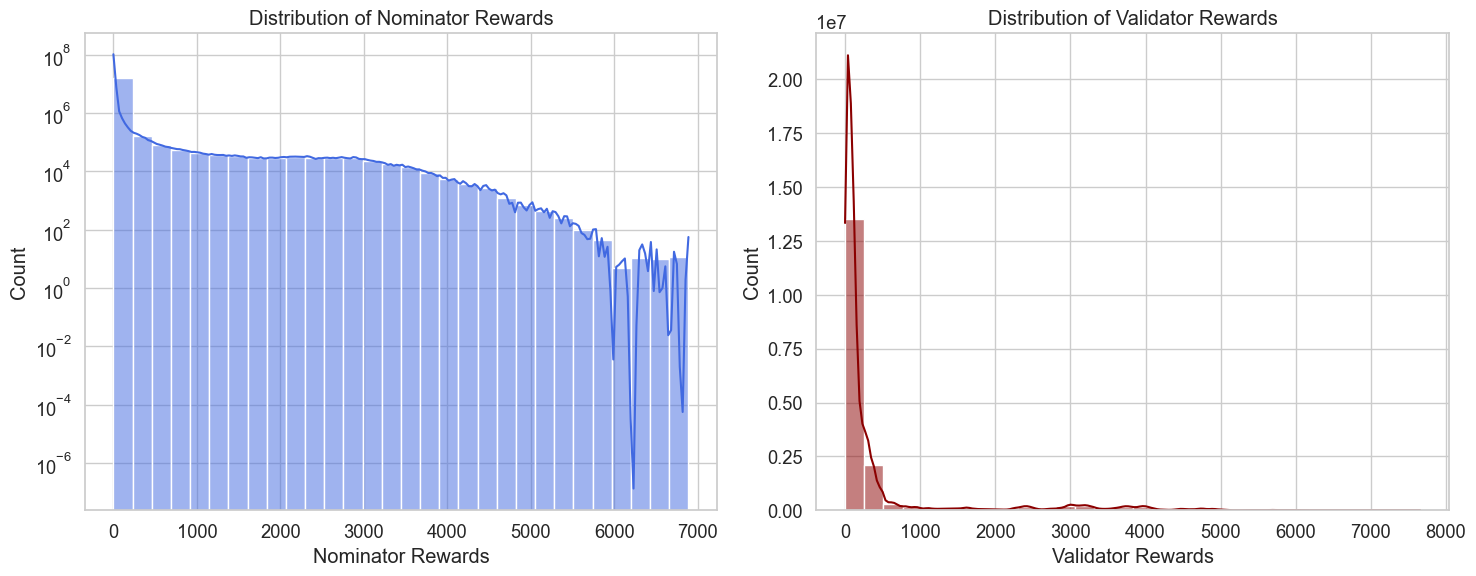

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it has columns 'nominator_reward' and 'validator_reward'

# Summary statistics
nominator_reward_summary = df['nominator_reward'].describe()
validator_reward_summary = df['validator_reward'].describe()

print("Summary statistics for nominator rewards:")
print(nominator_reward_summary)

print("\nSummary statistics for validator rewards:")
print(validator_reward_summary)

# Set Seaborn theme and default plot settings
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create a figure with a specific size
plt.figure(figsize=(15, 6))

# Histogram for nominator rewards
plt.subplot(1, 2, 1)
sns.histplot(df['nominator_reward']/(10**12)*365, log=True, kde=True, bins=30, color='royalblue', fill=True)
plt.xlabel('Nominator Rewards')
plt.ylabel('Count')
plt.title('Distribution of Nominator Rewards')

# Histogram for validator rewards
plt.subplot(1, 2, 2)
sns.histplot(df['validator_reward']/(10**12)*365, kde=True, bins=30, color='darkred', fill=True)
plt.xlabel('Validator Rewards')
plt.ylabel('Count')
plt.title('Distribution of Validator Rewards')

# Adjust layout
plt.tight_layout()
plt.savefig('Distribution Rewards.pdf')
plt.show()

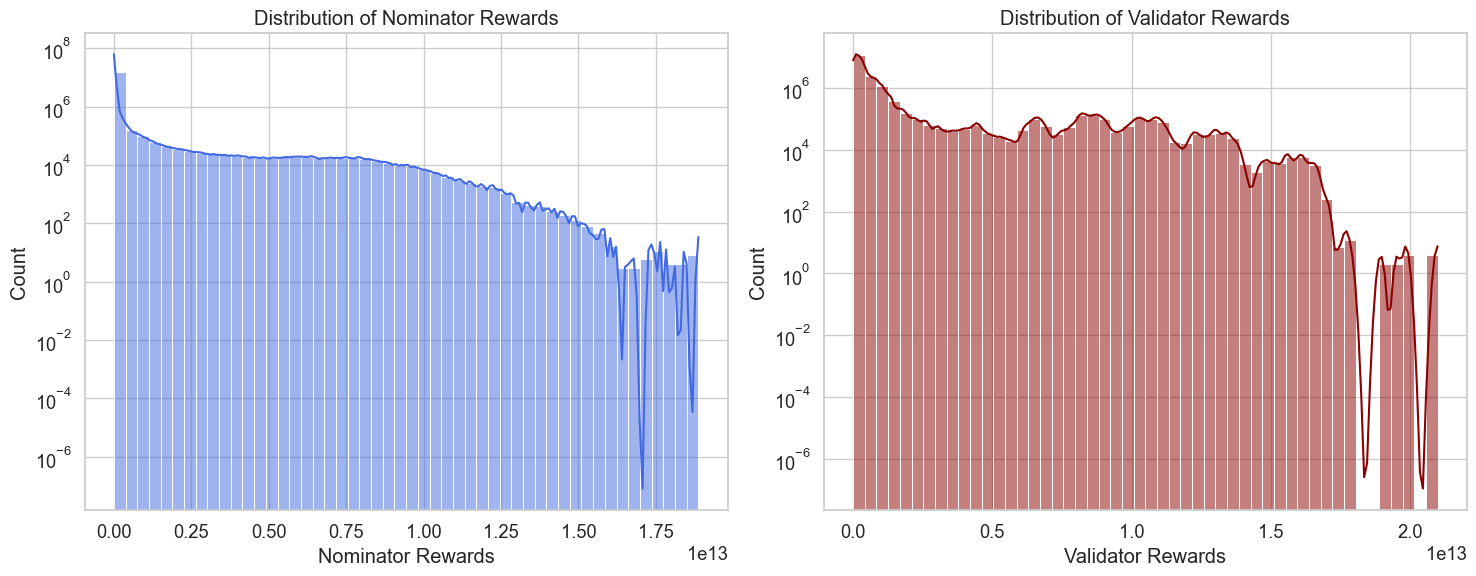

In [30]:
# Set Seaborn theme and default plot settings
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create a figure with a specific size
plt.figure(figsize=(15, 6))

# Histogram for nominator rewards
plt.subplot(1, 2, 1)
sns.histplot(df['nominator_reward'], log=True, kde=True, bins=50, color='royalblue', fill=True)
plt.xlabel('Nominator Rewards')
plt.ylabel('Count')
plt.title('Distribution of Nominator Rewards')

# Histogram for validator rewards
plt.subplot(1, 2, 2)
sns.histplot(df['validator_reward'],  log=True, kde=True, bins=50, color='darkred', fill=True)
plt.xlabel('Validator Rewards')
plt.ylabel('Count')
plt.title('Distribution of Validator Rewards')

# Adjust layout
plt.tight_layout()
plt.savefig('Distribution Rewards.pdf')
plt.show()